In [1]:
import os
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from attention_recreation.model import EncoderDecoder, make_decoder, make_encoder, make_input_id_encoder
from tokenizers import Tokenizer, decoders

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
BATCH_SIZE = 32

In [ ]:
# load data
ds = load_dataset("Helsinki-NLP/opus-100", "de-en", streaming=False)
en_generator = (x["translation"]["en"] for x in ds["train"])
de_generator = (x["translation"]["de"] for x in ds["train"])

# get tokenizers
en_tokenizer: Tokenizer = Tokenizer.from_file("../tokenizers/basic_en_tokenizer.json")
de_tokenizer: Tokenizer = Tokenizer.from_file("../tokenizers/basic_de_tokenizer.json")


# Preprocess and tokenize
def tokenize(example):
    en_encoded = en_tokenizer.encode(example["translation"]["en"])
    de_encoded = de_tokenizer.encode(example["translation"]["de"])
    return {"en_input_ids": en_encoded.ids, "de_input_ids": de_encoded.ids, "en_length": len(en_encoded.ids)}

tokenized_ds = ds.map(tokenize, remove_columns="translation", num_proc=os.cpu_count())
# filter out very long and short sentences they appear to be bad!
tokenized_ds = tokenized_ds.filter(lambda x: (x["en_length"] >= 4) & (x["en_length"] <= 45), num_proc=os.cpu_count())

en_pad_id = en_tokenizer.token_to_id("[PAD]")
de_pad_id = de_tokenizer.token_to_id("[PAD]")

train_en_lengths = tokenized_ds["train"]["en_length"]

In [6]:
class BatchSampler:
    def __init__(self, lengths, batch_size):
        """Shuffle idea taken from https://pi-tau.github.io/posts/transformer/#token-embedding-layer"""
        self.lengths = lengths
        self.batch_size = batch_size

    def __iter__(self):
        indicies = list(range(len(self.lengths)))
        shuffle(indicies)

        # yeild a pool of size 200 batch size
        step = 200 * self.batch_size
        for pool_start in range(0, len(self.lengths), step):
            pool = indicies[pool_start : pool_start + step]
            pool_sorted_by_lengths = sorted(pool, key=lambda i: self.lengths[i])

            for i in range(0, step, self.batch_size):
                yield pool_sorted_by_lengths[i : i + self.batch_size]

    def __len__(self):
        return len(self.lengths) // self.batch_size
    

def collate_fn(batch):
    seq_en_token_ids = [Tensor(x["en_input_ids"]) for x in batch]
    en_tokens_padded = pad_sequence(seq_en_token_ids, batch_first=True, padding_value=en_pad_id)
    
    seq_de_token_ids = [Tensor(x["de_input_ids"]) for x in batch]
    de_tokens_padded = pad_sequence(seq_de_token_ids, batch_first=True, padding_value=de_pad_id)

    return en_tokens_padded, de_tokens_padded

In [15]:
dataloader = DataLoader(
    dataset = tokenized_ds["train"].remove_columns("en_length").with_format("torch", device=device),
    batch_sampler=BatchSampler(train_en_lengths, BATCH_SIZE),
    collate_fn=collate_fn,
)

for en_tokens_padded, de_tokens_padded in dataloader:
    break

In [13]:
batch_sampler = BatchSampler(train_en_lengths, BATCH_SIZE)
for index_list in batch_sampler:
    print(index_list)
    print(ds["train"][index_list[0]])
    break

[460076, 529046, 426529, 574394, 353106, 376670, 507748, 814520, 68891, 268197, 516605, 526677, 387437, 187207, 612297, 532844, 641400, 73546, 634369, 263645, 15392, 807117, 722845, 816952, 326695, 831196, 610207, 613146, 48924, 5970, 286259, 57196]
{'translation': {'de': 'Schlechte Tisch-Selektion. Schau in die Lobby.', 'en': '31. Be sure you know the rules of the game.'}}


In [17]:
en_tokens_padded

tensor([[15350,  2316,  2420,  3294],
        [ 3486,    29,    59, 28600],
        [ 4834,  2272,  2585,    17],
        [ 2937,  2167,  5142,    17],
        [ 6224,    22,    18,    23],
        [ 2450,  2167,  5737,    34],
        [ 2394,  8128,  2204,    17],
        [ 2892,  2266,  4061,    17],
        [13379,  3007,  2274,  2589],
        [ 7332,  2356,  3624,    17],
        [14858,   784, 14387,    12],
        [ 5531,  4034,  2492,     4],
        [ 2259,  5571,  3448,  2881],
        [ 3614,  2607,  2173,    17],
        [ 5169,    68,  2440,    34],
        [ 7723,  5385,     9,  5352],
        [ 3113,  3188,  8161,    34],
        [ 2350,    17,  3307,  2764],
        [24925,    11,    20,    12],
        [12955,  3112,    92,     4],
        [ 2821,    15,  2955,     4],
        [ 2821,    15,  5622,    17],
        [   16,  3891,  2582,    17],
        [ 8568,    16,  7492,     4],
        [10502,  2178,    68,  9182],
        [16646,  2962, 20948, 26220],
        [ 35

In [18]:
data = tokenized_ds["train"]["en_length"]

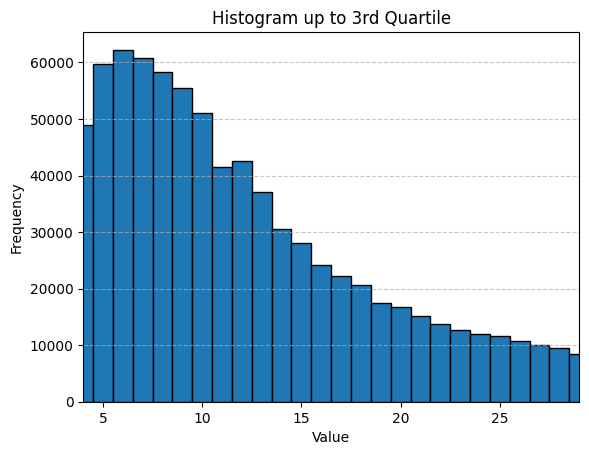

In [ ]:
# Calculate 75th percentile - no longer accurate since I filtered
q3 = np.percentile(data, 75)

# Create histogram
plt.hist(data, bins=range(min(data), max(data) + 2), edgecolor='black', align='left')
plt.title("Histogram up to 3rd Quartile")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set x-axis max to Q3 + 10
plt.xlim(left=min(data), right=q3+10)
plt.show()


In [8]:
for token_list, length in zip(processed_ds["train"][:BATCH_SIZE]["en_tokenized"], processed_ds["train"][:BATCH_SIZE]["en_length"]):
    print(token_list, length)

['It', "'", 's', 'gre', 'ed', 'that', 'it', "'", 's', 'gonna', 'be', 'the', 'death', 'of', 'you', ',', "'", 'cause', 'you', '...'] 20
['Ve', 'ga', '.'] 3
['Just', 'say', 'when', '.'] 4
['-', 'Wait', '.'] 3
['I', 'don', "'", 't', 'wanna', 'be', 'here', '.'] 8
['Okay', ',', 'so', '90', 'percent', 'of', 'my', 'photographic', 'process', 'is', ',', 'in', 'fact', ',', 'not', 'photographic', '.'] 17
['So', 'lovely', '.'] 3
['Thank', 'you', ',', 'colonel', '.'] 5
['Martin', '!'] 2
['Do', 'I', 'have', 'to', '?'] 5
['Please', 'sit', '.'] 3
['Leo', '!'] 2
['No', ',', 'honestly', ',', 'I', 'think', 'that', 'you', 'should', 'find', 'out', 'What', "'", 's', 'going', 'on', 'with', 'your', 'dad', '.'] 20
['How', 'you', 'holding', 'up', '?'] 5
['-', 'Let', "'", 's', 'go', '.'] 6
['I', 'am', 'really', 'allowed', 'to', 'get', 'up', ',', 'Doctor', '?'] 10
['-', 'What', 'will', 'you', 'do', 'with', 'it', '?'] 8
['-', 'Can', 'we', 'talk', '?'] 5
['Get', 'down', '!'] 3
['And', 'if', 'the', 'dis', 'ruption', 

model stuff

In [3]:
d_model=512
d_inner_layer=2048
n_heads=8
n_encoder_stacks=7
n_decoder_stacks=7
source_vocab_size=en_tokenizer.get_vocab_size()
target_vocab_size = de_tokenizer.get_vocab_size()

In [4]:
encoder_decoder_model = EncoderDecoder(
    d_model=d_model,
    d_inner_layer=d_inner_layer,
    n_heads=n_heads,
    n_encoder_stacks=n_encoder_stacks,
    n_decoder_stacks=n_decoder_stacks,
    source_vocab_size=source_vocab_size,
    target_vocab_size=target_vocab_size,
    input_id_encoder_factory=make_input_id_encoder,
    encoder_factory=make_encoder,
    decoder_factory=make_decoder,
)

In [5]:

encoder_decoder_model

EncoderDecoder(
  (source_id_encoder): InputIdEncoder(
    (token_encoder): Embedding(30000, 512)
    (positional_encoder): SinePositionEncoder(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (target_id_encoder): InputIdEncoder(
    (token_encoder): Embedding(30000, 512)
    (positional_encoder): SinePositionEncoder(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-6): 7 x EncoderLayer(
        (mha_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mha_sublayer): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (mha_dropout): Dropout(p=0.1, inplace=False)
        (mlp_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp_sublayer): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): Linear(in_features=2048, out_features=512, bia